# Unfold

- Closure Tests and Fake Data Tests
- Only need MC stat and GENIE syst

In [1]:
# %load_ext autoreload
# %autoreload 2

# #print all output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm
import pickle

# local imports
from variable_configs import *

sys.path.append('../../')
from analysis_village.unfolding.wienersvd import *
from analysis_village.unfolding.unfolding_inputs import *
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from makedf.geniesyst import regen_systematics_sbnd_multisigma, regen_systematics_sbnd_morph
from makedf.constants import *

plt.style.use("presentation.mplstyle")
# plt.style.use('seaborn-v0_8-colorblind')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=plt.get_cmap('Set2').colors)
# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=sns.color_palette("hls", 8))



# filter Performance warning
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [3]:
save_fig = False
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/unfolding_data"

# load dataframes

In [4]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"

## -- MC 
# selected
mc_file = path.join(file_dir, "MC_bnb_cosmics_finalsel.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 5
Keys: ['/evt_0', '/evt_1', '/evt_2', '/evt_3', '/evt_4', '/hdr_0', '/hdr_1', '/hdr_2', '/hdr_3', '/hdr_4', '/mcnu_0', '/mcnu_1', '/mcnu_2', '/mcnu_3', '/mcnu_4', '/split']


In [5]:
# concat dfs 
n_max_concat = 20

mc_keys2load = ['hdr', 'evt', 'mcnu']
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']
mc_nu_df = mc_dfs['mcnu']

In [6]:
data_file = path.join(file_dir, "Data_dev_sel_v5.df")
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

data_keys2load = ['evt', 'hdr']
data_dfs = load_dfs(data_file, data_keys2load, n_max_concat=n_max_concat)
data_evt_df = data_dfs['evt']
data_hdr_df = data_dfs['hdr']

data_n_split: 2
Keys: ['/bnbpot_0', '/bnbpot_1', '/evt_0', '/evt_1', '/hdr_0', '/hdr_1', '/split', '/trk_0', '/trk_1']


In [7]:
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name
P_mu_col = pad_column_name(("totp",), mc_nu_df.mu)
P_p_col = pad_column_name(("totp",), mc_nu_df.p)
ret_tki = get_cc1p0pi_tki(mc_nu_df.mu, mc_nu_df.p, P_mu_col, P_p_col)
mc_nu_df["del_Tp"] = ret_tki["del_Tp"]
mc_nu_df["del_Tp_x"] = ret_tki["del_Tp_x"]
mc_nu_df["del_Tp_y"] = ret_tki["del_Tp_y"]
mc_nu_df["del_p"] = ret_tki["del_p"]
mc_nu_df["del_alpha"] = ret_tki["del_alpha"]
mc_nu_df["del_phi"] = ret_tki["del_phi"]

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
data_tot_pot = data_hdr_df['pot'].sum()
print("data_tot_pot: %.3e" %(data_tot_pot))

mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.10e" %(mc_tot_pot))

mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

# mc_tot_pot = mc_hdr_df['pot'].sum()
# print("mc_tot_pot: %.10e" %(mc_tot_pot))

# mc_pot_scale = data_tot_pot / mc_tot_pot
# mc_pot_scale = 1.0
# print("mc_pot_scale: %.3e" %(mc_pot_scale))
# mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

data_tot_pot: 4.679e+18
mc_tot_pot: 5.8562716084e+20
mc_pot_scale: 7.990e-03


In [9]:
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_evt_df.loc[:,'genie_categ'] = get_genie_category(mc_evt_df)
print(mc_evt_df.nuint_categ.value_counts())
print(mc_evt_df.genie_categ.value_counts())

mc_nu_df.loc[:,'nuint_categ'] = get_int_category(mc_nu_df)
mc_nu_df.loc[:,'genie_categ'] = get_genie_category(mc_nu_df)
print(mc_nu_df.nuint_categ.value_counts())
print(mc_nu_df.genie_categ.value_counts())

nuint_categ
 1    73575
 2     2279
 3     2238
 4     1176
-1      393
 5       98
 0       82
Name: count, dtype: int64
genie_categ
 1    65266
 2     9586
 3     3130
 6     1176
-1      393
 4      101
 7       98
 0       82
 5        9
Name: count, dtype: int64
nuint_categ
0    8678581
3    1296685
4     941525
1     744745
2     328118
5      55677
Name: count, dtype: int64
genie_categ
0    8678581
1    1253365
6     941525
3     668227
2     317791
4     125984
7      55677
5       4181
Name: count, dtype: int64


# load covariance matrices

In [10]:
# with open("/exp/sbnd/data/users/munjung/xsec/2025B/frac_cov_matrices_uboone.pkl", "rb") as f:
#     frac_cov_matrices = pickle.load(f)

# frac_cov_matrices.keys()

In [11]:
# # collect uncertainties / cov matrices from files

# # single bin uncertainties
# frac_cov_matrices = {}

# data_dir = "/exp/sbnd/data/users/munjung/xsec/2025B"
# with open(path.join(data_dir, "frac_cov_matrices_multisim_1_singlebin.pkl"), "rb") as f:
#     temp = pickle.load(f)
# frac_cov_matrices['singlebin'] = temp['singlebin']
# print(len(frac_cov_matrices['singlebin'].keys()))

# with open(path.join(data_dir, "frac_cov_matrices_multisim_2_singlebin.pkl"), "rb") as f:
#     temp = pickle.load(f)
# for k in temp['singlebin'].keys():
#     frac_cov_matrices['singlebin'][k] = temp['singlebin'][k]
# print(len(frac_cov_matrices['singlebin'].keys()))

# with open(path.join(data_dir, "frac_cov_matrices_other_singlebin.pkl"), "rb") as f:
#     temp = pickle.load(f)
# for k in temp['singlebin'].keys():
#     frac_cov_matrices['singlebin'][k] = temp['singlebin'][k]
# print(len(frac_cov_matrices['singlebin'].keys()))

# with open(path.join(data_dir, "frac_cov_matrices_zexp.pkl"), "rb") as f:
#     temp = pickle.load(f)
# for k in temp['singlebin'].keys():
#     frac_cov_matrices['singlebin'][k] = temp['singlebin'][k]
# print(len(frac_cov_matrices['singlebin'].keys()))

# # for varkey in temp.keys():
# for varkey in ['mu_totp']:
#     with open(path.join(data_dir, "frac_cov_matrices_multisim_1.pkl"), "rb") as f:
#         temp = pickle.load(f)
#     print(temp.keys())
#     frac_cov_matrices[varkey] = temp[varkey]
#     print(len(frac_cov_matrices[varkey].keys()))

#     with open(path.join(data_dir, "frac_cov_matrices_multisim_2.pkl"), "rb") as f:
#         temp = pickle.load(f)
#     for k in temp[varkey].keys():
#         frac_cov_matrices[varkey][k] = temp[varkey][k]
#     print(len(frac_cov_matrices[varkey].keys()))

#     # with open(path.join(data_dir, "frac_cov_matrices.pkl"), "rb") as f:
#     #     temp = pickle.load(f)
#     # for k in temp[varkey].keys():
#     #     frac_cov_matrices[varkey][k] = temp[varkey][k]
#     # print(len(frac_cov_matrices[varkey].keys()))

#     try:
#         with open(path.join(data_dir, "frac_cov_matrices_other.pkl"), "rb") as f:
#             temp = pickle.load(f)
#         for k in temp[varkey].keys():
#             frac_cov_matrices[varkey][k] = temp[varkey][k]
#         print(len(frac_cov_matrices[varkey].keys()))
#     except:
#         print("No other covariance matrices found for %s" % varkey)

#     # try:
#     #     with open(path.join(data_dir, "frac_cov_matrices_other_tki.pkl"), "rb") as f:
#     #         temp = pickle.load(f)
#     #     for k in temp[varkey].keys():
#     #         frac_cov_matrices[varkey][k] = temp[varkey][k]
#     #     print(len(frac_cov_matrices[varkey].keys()))
#     # except:
#     #     print("No other covariance matrices found for %s" % varkey)

#     with open(path.join(data_dir, "frac_cov_matrices_zexp.pkl"), "rb") as f:
#         temp = pickle.load(f)
#     for k in temp[varkey].keys():
#         frac_cov_matrices[varkey][k] = temp[varkey][k]
#     print(len(frac_cov_matrices[varkey].keys()))

In [12]:
# data_dir = "/exp/sbnd/data/users/munjung/xsec/2025B"
# with open(path.join(data_dir, "frac_cov_matrices_other.pkl"), "rb") as f:
#     temp = pickle.load(f)
# print(temp['mu_totp'].keys())

# # multisim
# with open(path.join(data_dir, "frac_cov_matrices_other_singlebin.pkl"), "rb") as f:
#     temp = pickle.load(f)
# print(temp['singlebin'].keys())

# with open(path.join(data_dir, "frac_cov_matrices.pkl"), "rb") as f:
#     temp = pickle.load(f)
# print(temp.keys())
# print(temp['mu_totp'].keys())


In [13]:
# Total uncertainty is obtained by summing all multisigmas with the multisim prod
data_dir = "/exp/sbnd/data/users/munjung/xsec/2025B"

# flux, cosmics, mcstat, singlebin, multisigma
with open(path.join(data_dir, "frac_cov_matrices_final.pkl"), "rb") as f:
    frac_cov_matrices_multisig = pickle.load(f)

# multisim
with open(path.join(data_dir, "frac_cov_matrices_multisim_prod.pkl"), "rb") as f:
    frac_cov_matrices_multisim_prod = pickle.load(f)

In [14]:
frac_cov_matrices_multisig['del_Tp']['GENIEReWeight_SBN_v1_multisigma_VecFFCCQEshape'].shape

(13, 13)

In [15]:
# frac_cov_matrices_multisig['mu_totp'].keys()
# frac_cov_matrices_multisim_prod['mu_totp'].keys()
# for vartag in ['mu_totp', 'mu_dir_z', ]:
for vartag in frac_cov_matrices_multisig.keys():

    tot_genie_frac_cov = frac_cov_matrices_multisim_prod[vartag]['genie_multisims']
    if vartag == 'singlebin':
        tot_genie_unc_sq = tot_genie_frac_cov ** 2

    for k in frac_cov_matrices_multisig[vartag].keys():
        if "multisigma" in k or "zexp" in k:
            if vartag == 'singlebin':
                # print(frac_cov_matrices_multisig[vartag][k])
                tot_genie_unc_sq = tot_genie_unc_sq + frac_cov_matrices_multisig[vartag][k]**2
            else:
                tot_genie_frac_cov = tot_genie_frac_cov + frac_cov_matrices_multisig[vartag][k]

    frac_cov_matrices_multisig[vartag]['genie_total'] = tot_genie_frac_cov
    if vartag == 'singlebin':
        frac_cov_matrices_multisig[vartag]['genie_total'] = np.sqrt(tot_genie_unc_sq)
        print(np.sqrt(tot_genie_unc_sq))
    else:
        print(np.sqrt(np.diag(tot_genie_frac_cov)))

[0.03053777]
[0.04063    0.03019425 0.0321273  0.03674989 0.03326003 0.03594319
 0.0414295  0.03522729 0.03755375 0.03735927 0.03515143 0.03005599
 0.04279506 0.04792853]
[0.05765006 0.03547262 0.04883702 0.03980679 0.03677835 0.03598436
 0.03362827 0.04874728 0.05341683 0.06303891 0.06015025 0.05344943
 0.04166718 0.05514953]
[0.10719147 0.07052587 0.03875124 0.03127426 0.02113326 0.01963179
 0.01709016 0.01306186 0.01712246 0.01991226 0.02567772 0.03074168
 0.060278   0.11982722]
[0.26126106 0.19998552 0.16441754 0.1337616  0.13449484 0.14633532
 0.11406713 0.08585505 0.06077184 0.03990771 0.02891693 0.02979938
 0.0308471  0.03326177]
[0.03346321 0.02888507 0.02214587 0.02644992 0.02351757 0.02449349
 0.03843815]
[0.01377646 0.01512318 0.0176382  0.02473179 0.03234625 0.0419413
 0.05096955 0.07055523 0.08036558 0.08958274 0.1092309  0.1362827
 0.18832751]
[0.02106647 0.0267684  0.03251085 0.04555162 0.05040401 0.05367108
 0.0627685  0.06391092 0.05992898 0.08090619 0.09092891 0.07765

## Detailed xsec uncertainties plots

In [16]:
save_fig = True
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/xsec_syst"

In [17]:
frac_cov_matrices = frac_cov_matrices_multisig

In [18]:
var_config = VariableConfig.muon_momentum()

In [25]:
frac_cov_matrices['mu_totp'].keys()

dict_keys(['genie_multisim_GENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_NCELVariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_RPA_CCQE', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_CoulombCCQE', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_NormCCMEC', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_NormNCMEC', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_CCRESVariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_NCRESVariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_RDecBR1gamma', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_RDecBR1eta', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_COHVariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_DISBYVariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_FSI_pi_VariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_FSI_N_VariationResponse', 'genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC1pi', 'gen

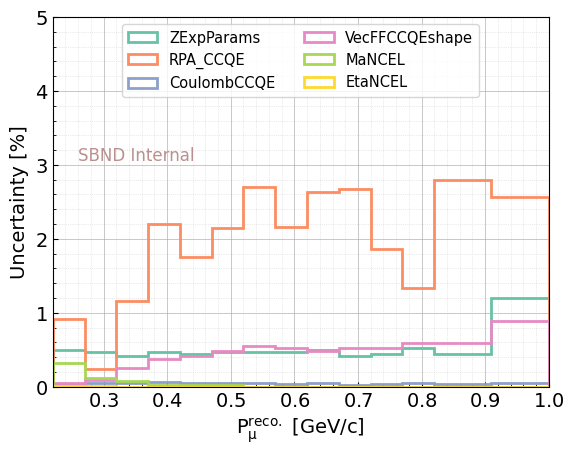

In [19]:
# CC QE
this_keys = [
"genie_zexp",
# "GENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse",
"GENIEReWeight_SBN_v1_multisim_RPA_CCQE",
"GENIEReWeight_SBN_v1_multisim_CoulombCCQE",
"GENIEReWeight_SBN_v1_multisigma_VecFFCCQEshape",
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_NCELVariationResponse",
"GENIEReWeight_SBN_v1_multisigma_MaNCEL",
"GENIEReWeight_SBN_v1_multisigma_EtaNCEL",
]
for k in this_keys:
    if "flux" in k or "mcstat" in k:
        continue
    longer_key = "genie_multisim_"+k
    if k in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp'][k]))
    elif longer_key in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp']['genie_multisim_'+k]))
    lname = k.replace("GENIEReWeight_SBN_v1_multisim_", "")
    lname = lname.replace("GENIEReWeight_SBN_v1_multisigma_", "")
    lname = lname.replace("genie_multisim_", "")
    if k == "genie_zexp":
        lname = "ZExpParams"
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=unc*1e2, histtype="step", 
             label=lname, linewidth=2)


plt.text(0.05, 0.65, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=10.5, ncol=2, loc="upper center", reverse=False)
plt.ylim(0, 5)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig(path.join(save_fig_dir, "xsec_syst_1.png"), dpi=300, bbox_inches="tight")
plt.show();

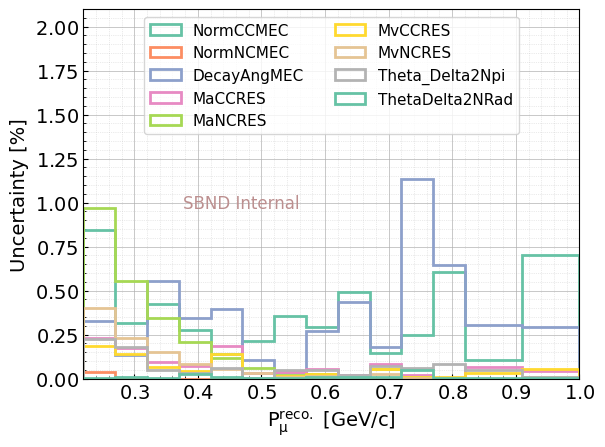

In [20]:
# CC MEC & RES
this_keys = [
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NormCCMEC",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NormNCMEC",
"GENIEReWeight_SBN_v1_multisigma_DecayAngMEC",
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_CCRESVariationResponse",
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_NCRESVariationResponse",
"GENIEReWeight_SBN_v1_multisigma_MaCCRES",
"GENIEReWeight_SBN_v1_multisigma_MaNCRES",
"GENIEReWeight_SBN_v1_multisigma_MvCCRES",
"GENIEReWeight_SBN_v1_multisigma_MvNCRES",
"GENIEReWeight_SBN_v1_multisigma_Theta_Delta2Npi",
"GENIEReWeight_SBN_v1_multisigma_ThetaDelta2NRad",
]
for k in this_keys:
    if "flux" in k or "mcstat" in k:
        continue
    longer_key = "genie_multisim_"+k
    if k in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp'][k]))
    elif longer_key in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp']['genie_multisim_'+k]))
    lname = k.replace("GENIEReWeight_SBN_v1_multisim_", "")
    lname = lname.replace("GENIEReWeight_SBN_v1_multisigma_", "")
    lname = lname.replace("genie_multisim_", "")
    if k == "genie_zexp":
        lname = "ZExpParams"
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=unc*1e2, histtype="step", 
             label=lname, linewidth=2)

plt.text(0.2, 0.5, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=2, loc="upper center", reverse=False)
plt.ylim(0, 2.1)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig(path.join(save_fig_dir, "xsec_syst_2.png"), dpi=300, bbox_inches="tight")
plt.show();

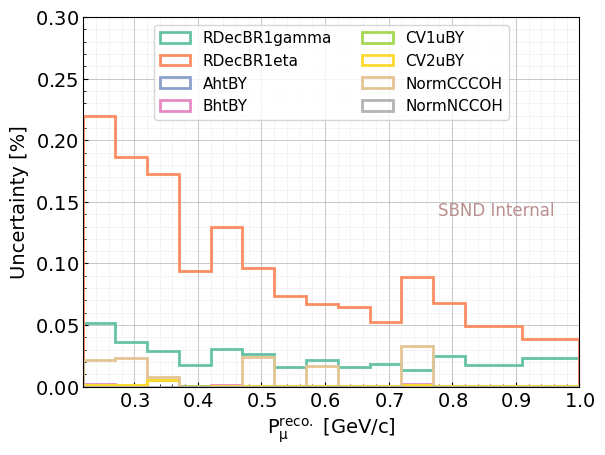

In [21]:
# CC Other
this_keys = [
"genie_multisim_GENIEReWeight_SBN_v1_multisim_RDecBR1gamma",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_RDecBR1eta",
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_COHVariationResponse",
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_DISBYVariationResponse",
"GENIEReWeight_SBN_v1_multisigma_AhtBY",
"GENIEReWeight_SBN_v1_multisigma_BhtBY",
"GENIEReWeight_SBN_v1_multisigma_CV1uBY",
"GENIEReWeight_SBN_v1_multisigma_CV2uBY",
"GENIEReWeight_SBN_v1_multisigma_NormCCCOH",
"GENIEReWeight_SBN_v1_multisigma_NormNCCOH",
]
for k in this_keys:
    if "flux" in k or "mcstat" in k:
        continue
    longer_key = "genie_multisim_"+k
    if k in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp'][k]))
    elif longer_key in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp']['genie_multisim_'+k]))
    lname = k.replace("GENIEReWeight_SBN_v1_multisim_", "")
    lname = lname.replace("GENIEReWeight_SBN_v1_multisigma_", "")
    lname = lname.replace("genie_multisim_", "")
    if k == "genie_zexp":
        lname = "ZExpParams"
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=unc*1e2, histtype="step", 
             label=lname, linewidth=2)

plt.text(0.95, 0.5, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='right', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=2, loc="upper center", reverse=False)
plt.ylim(0, 0.3)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig(path.join(save_fig_dir, "xsec_syst_3.png"), dpi=300, bbox_inches="tight")
plt.show();

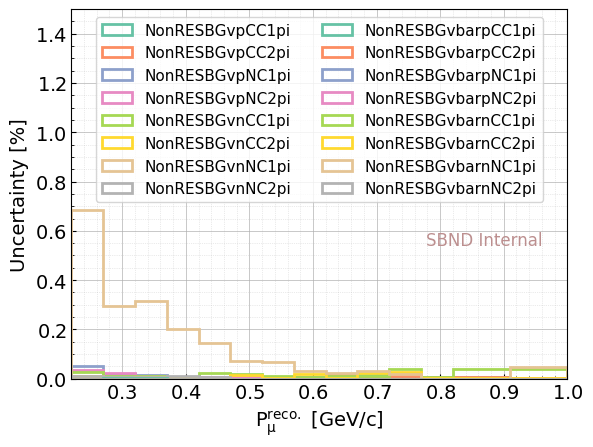

In [22]:
# CC Other
this_keys = [
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvpNC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvpNC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvnCC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvnCC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvnNC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvnNC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpCC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpCC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpNC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpNC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnCC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnCC2pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnNC1pi",
"genie_multisim_GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnNC2pi",
]
for k in this_keys:
    if "flux" in k or "mcstat" in k:
        continue
    longer_key = "genie_multisim_"+k
    if k in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp'][k]))
    elif longer_key in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp']['genie_multisim_'+k]))
    lname = k.replace("GENIEReWeight_SBN_v1_multisim_", "")
    lname = lname.replace("GENIEReWeight_SBN_v1_multisigma_", "")
    lname = lname.replace("genie_multisim_", "")
    if k == "genie_zexp":
        lname = "ZExpParams"
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=unc*1e2, histtype="step", 
             label=lname, linewidth=2)

plt.text(0.95, 0.4, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='right', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=2, loc="upper center", reverse=False)
plt.ylim(0, 1.5)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig(path.join(save_fig_dir, "xsec_syst_4.png"), dpi=300, bbox_inches="tight")
plt.show();

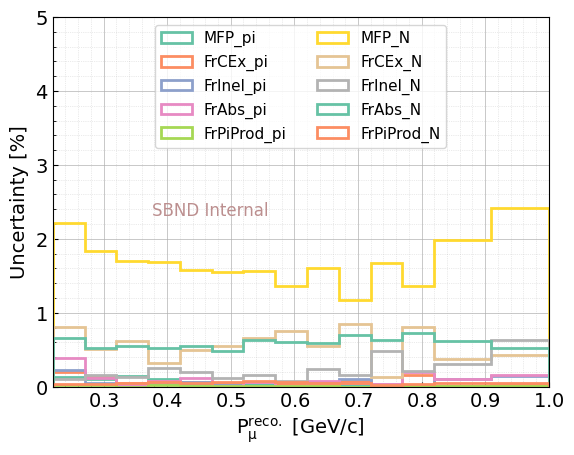

In [23]:
# CC Other
this_keys = [
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_FSI_pi_VariationResponse",
# "genie_multisim_GENIEReWeight_SBN_v1_multisim_FSI_N_VariationResponse",
"GENIEReWeight_SBN_v1_multisigma_MFP_pi",
"GENIEReWeight_SBN_v1_multisigma_FrCEx_pi",
"GENIEReWeight_SBN_v1_multisigma_FrInel_pi",
"GENIEReWeight_SBN_v1_multisigma_FrAbs_pi",
"GENIEReWeight_SBN_v1_multisigma_FrPiProd_pi",
"GENIEReWeight_SBN_v1_multisigma_MFP_N",
"GENIEReWeight_SBN_v1_multisigma_FrCEx_N",
"GENIEReWeight_SBN_v1_multisigma_FrInel_N",
"GENIEReWeight_SBN_v1_multisigma_FrAbs_N",
"GENIEReWeight_SBN_v1_multisigma_FrPiProd_N",
]
for k in this_keys:
    if "flux" in k or "mcstat" in k:
        continue
    longer_key = "genie_multisim_"+k
    if k in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp'][k]))
    elif longer_key in frac_cov_matrices['mu_totp'].keys():
        unc = np.sqrt(np.diag(frac_cov_matrices['mu_totp']['genie_multisim_'+k]))
    lname = k.replace("GENIEReWeight_SBN_v1_multisim_", "")
    lname = lname.replace("GENIEReWeight_SBN_v1_multisigma_", "")
    lname = lname.replace("genie_multisim_", "")
    if k == "genie_zexp":
        lname = "ZExpParams"
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=unc*1e2, histtype="step", 
             label=lname, linewidth=2)

plt.text(0.2, 0.5, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=2, loc="upper center", reverse=False)
plt.ylim(0, 5)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig(path.join(save_fig_dir, "xsec_syst_5.png"), dpi=300, bbox_inches="tight")
plt.show();

In [50]:
frac_cov_matrices.keys()
with open(path.join(data_dir, "frac_cov_matrices.pkl"), "rb") as f:
    temp = pickle.load(f)
for k in temp.keys():
    # if k == "singlebin":
    #     continue
    # print(k)
    if frac_cov_matrices.get(k) is None:
        frac_cov_matrices[k] = {}
    frac_cov_matrices[k]['flux'] = temp[k]['flux']
    frac_cov_matrices[k]['mcstat'] = temp[k]['mcstat']
    frac_cov_matrices[k]['cosmics'] = temp[k]['cosmics']

    for sk in temp[k].keys():
        if "multisigma" in sk:
            # print(sk)
            frac_cov_matrices[k][sk] = temp[k][sk]
frac_cov_matrices.keys()

dict_keys(['singlebin', 'mu_totp', 'mu_dir_z', 'p_totp', 'p_dir_z', 'del_alpha', 'del_Tp', 'del_phi'])

In [51]:
# frac_cov_matrices['singlebin']['cosmics']
with open(path.join(data_dir, "frac_cov_matrices_other_tki.pkl"), "rb") as f:
    temp = pickle.load(f)
# temp['singlebin']['cosmics']

In [ ]:
# frac_cov_matrices
# with open(path.join(data_dir, "frac_cov_matrices_final_2.pkl"), "wb") as f:
#     pickle.dump(frac_cov_matrices, f)

# Constants

['flux_sbnd_numu;1', 'flux_sbnd_nue;1', 'flux_sbnd_anumu;1', 'flux_sbnd_anue;1']


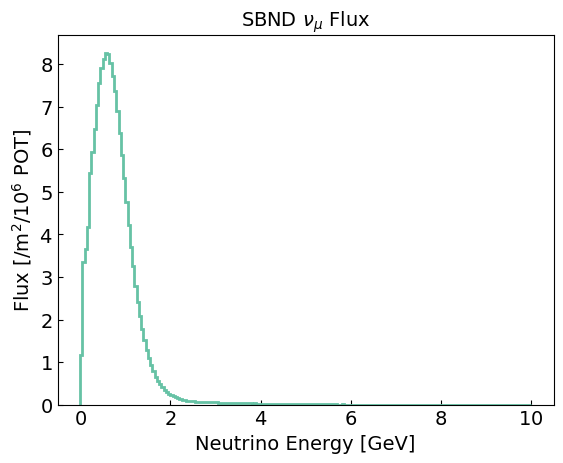

Integrated flux: 7.557e+10


In [30]:
# TODO: z-dependence?
# flux file, units: /m^2/10^6 POT 
# 50 MeV bins
fluxfile = "/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root"
flux = uproot.open(fluxfile)
print(flux.keys())

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

plt.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step", linewidth=2)
plt.xlabel("Neutrino Energy [GeV]")
plt.ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
plt.title("SBND $\\nu_\\mu$ Flux")

# if save_fig:
#     plt.savefig("{}/sbnd-flux.pdf".format(save_fig_dir))
plt.savefig("sbnd-flux.pdf", bbox_inches='tight')
plt.show()

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = integrated_flux * data_tot_pot / 1e6 # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

In [31]:
V_SBND = 380 * 380 * 440 # cm3, the active volume of the detector 
NTARGETS = RHO * V_SBND * N_A / M_AR
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


In [32]:
# set to 1 for event rates
XSEC_UNIT = 1 / (INTEGRATED_FLUX * NTARGETS)
print("xsec unit: ", XSEC_UNIT)

xsec unit:  9.986454504378764e-42


# Unfold

## Choose variable to unfold

In [123]:
# choose a variable to unfold, defined in variable_configs.py
# var_config = VariableConfig.muon_momentum()
# var_config = VariableConfig.muon_direction()
# var_config = VariableConfig.proton_momentum()
# var_config = VariableConfig.proton_direction()
# var_config = VariableConfig.tki_del_Tp()
# var_config = VariableConfig.tki_del_alpha()
var_config = VariableConfig.tki_del_phi()

# single bin
# var_config.bins = np.array([var_config.bins[0], var_config.bins[-1]])
# var_config.bin_centers = np.array([var_config.bin_centers[0], var_config.bin_centers[-1]])
# var_config.var_save_name = var_config.var_save_name + "_singlebin"


In [124]:
# Total MC reco muon momentum: for fake data
eps = 1e-8
var_total_mc = mc_evt_df[var_config.var_evt_reco_col]
var_total_mc = np.clip(var_total_mc, var_config.bins[0], var_config.bins[-1] - eps)
weights_total_mc = mc_evt_df.loc[:, 'pot_weight']

# --- all events, selected ---
# mc_evt_df divided into topology modes for subtraction from data in future
# first item in list is the signal topology
mc_evt_df_divided = [mc_evt_df[mc_evt_df.nuint_categ == mode]for mode in topology_list]

# Reco variable distribution for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.nuint_categ == mode][var_config.var_evt_reco_col]for mode in topology_list]
var_per_nuint_categ_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.nuint_categ == mode, 'pot_weight'] for mode in topology_list]

# Reco variable distribution for each genie mode
var_per_genie_mode_mc = [mc_evt_df[mc_evt_df.genie_categ == mode][var_config.var_evt_reco_col]for mode in genie_mode_list]
var_per_genie_mode_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_genie_mode_mc]
weights_per_genie_mode = [mc_evt_df.loc[mc_evt_df.genie_categ == mode, 'pot_weight'] for mode in genie_mode_list]


# --- signal events ---
# selected, for response matrix
# Signal event's reco muon momentum after the event selection
var_signal_sel_reco = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_reco_col]
var_signal_sel_reco = np.clip(var_signal_sel_reco, var_config.bins[0], var_config.bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection
var_signal_sel_truth = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_truth_col]
var_signal_sel_truth = np.clip(var_signal_sel_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# total generated, for efficiency vector
# Signal event's true muon momentum without event selection
var_truth_signal = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_truth_signal = np.clip(var_truth_signal, var_config.bins[0], var_config.bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

# Response Matrix

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[2274.02191805 1382.41860765  698.10897187  389.74534813  220.54167648
  242.02773018  181.4289086   143.85028809  141.82073895  106.35956145
   84.40207705   85.38489022]
[201.78832281 142.87546528  82.21272089  47.87019252  24.67420372
  25.28946075  18.42574928  14.09497907  12.34509221   8.00633165
   5.49736145   4.77023952]
[223.10657914 141.45318281  76.55555242  42.38082142  21.94949405
  23.1959888   17.34705191  12.6407352   11.98552642   7.51892024
   5.22568952   4.46660618]


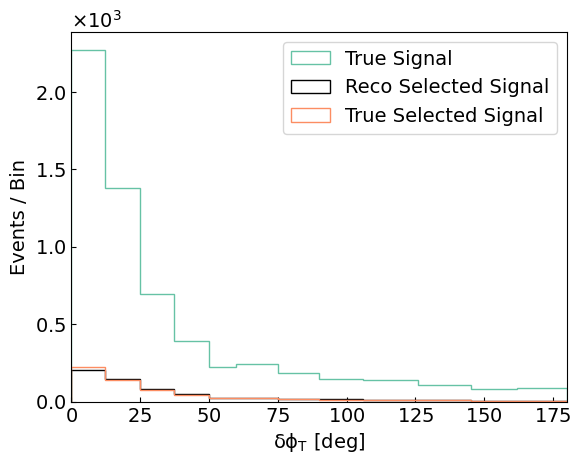

In [125]:
nevts_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_truth_signal, histtype="step", label="True Signal")
nevts_signal_sel_reco, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=weight_signal, histtype="step", label="Reco Selected Signal", color="k")
nevts_signal_sel_truth, _, _ = plt.hist(var_signal_sel_truth, bins=var_config.bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(nevts_signal_truth)
print(nevts_signal_sel_reco)
print(nevts_signal_sel_truth)
plt.legend()
plt.ylabel("Events / Bin")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
if save_fig:
    plt.savefig("{}/{}-sel_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show();

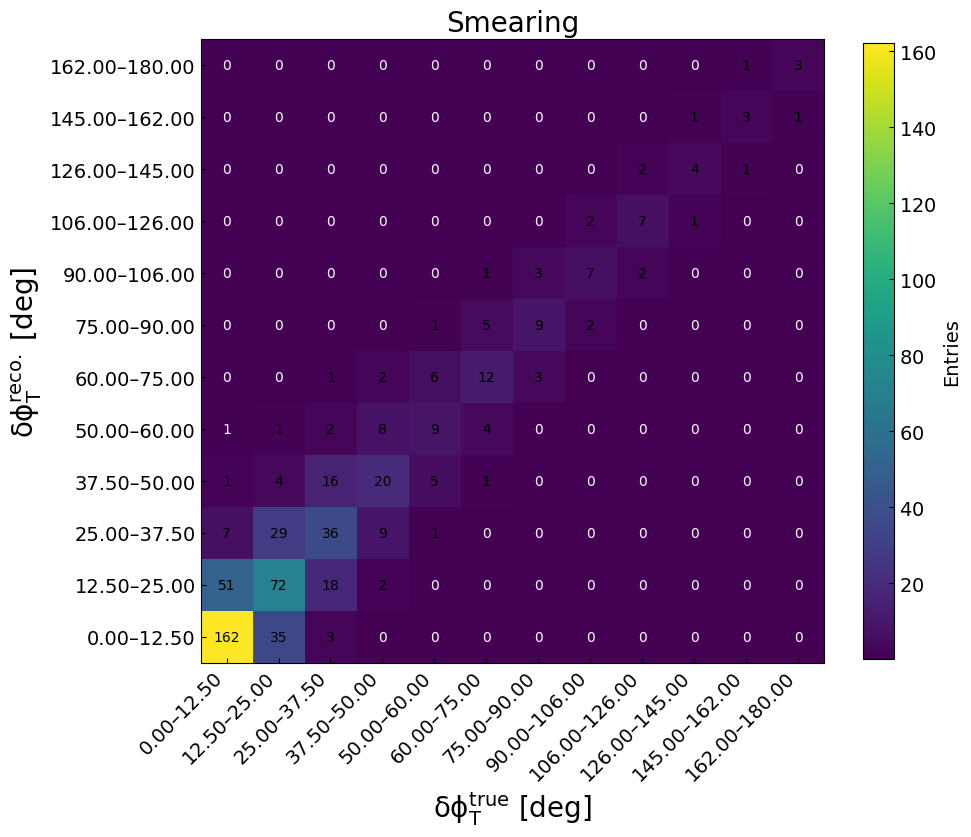

eff
[0.09810398 0.10232297 0.10966132 0.10873977 0.09952538 0.09584021
 0.09561349 0.0878187  0.0845118  0.07069341 0.06181956 0.05221786]


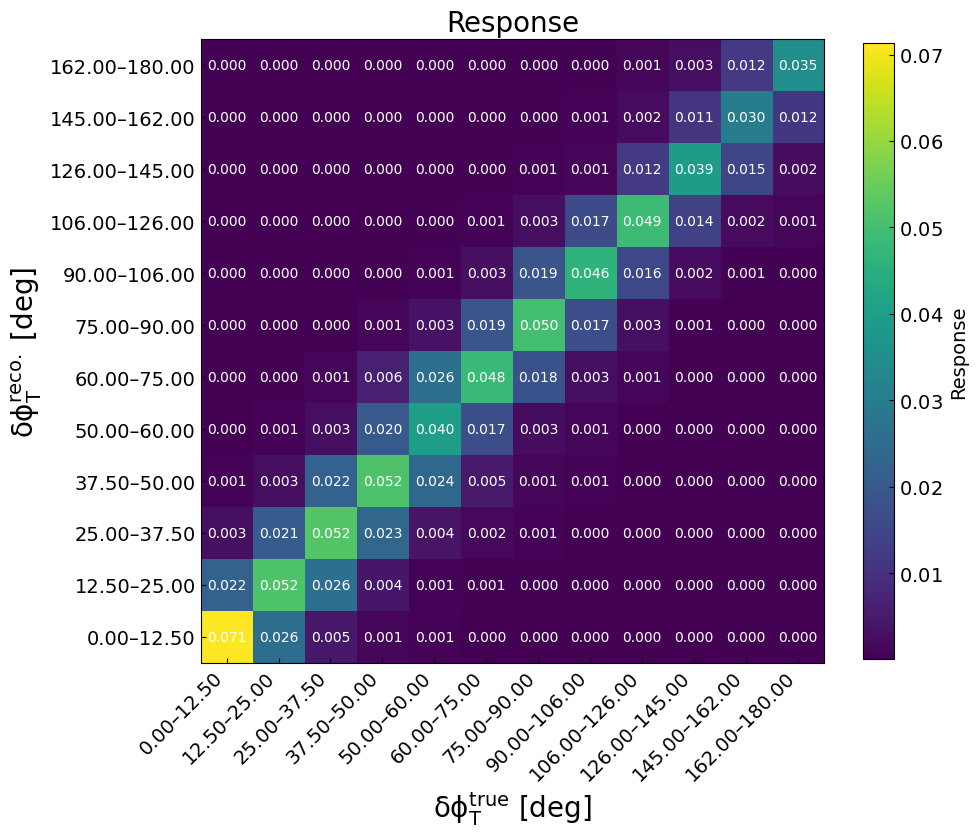

In [126]:
bins_2d = [var_config.bins, var_config.bins]

save_fig_name = "{}/{}-reco_vs_true".format(save_fig_dir, var_config.var_save_name)
reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, bins_2d, var_labels=var_config.var_labels,
                                weights=mc_evt_df[mc_evt_df.nuint_categ == 1]["pot_weight"],
                                save_fig=save_fig, save_fig_name=save_fig_name)
eff = get_eff(reco_vs_true, nevts_signal_truth)
print("eff")
print(eff)

save_fig_name = "{}/{}-response_matrix".format(save_fig_dir, var_config.var_save_name)
Response = get_response_matrix(reco_vs_true, eff, var_config.bins, var_labels=var_config.var_labels,
                               save_fig=save_fig, save_fig_name=save_fig_name)

# Covariance Matrix

In [127]:
def cov_from_fraccov(cov_frac, cv_vals):
    cov = np.zeros_like(cov_frac)
    for i in range(len(var_config.bins)-1):
        for j in range(len(var_config.bins)-1):
            cov[i, j] = cov_frac[i, j] * (cv_vals[i] * cv_vals[j])
    return cov

def corr_from_fraccov(cov_frac):
    corr = np.zeros_like(cov_frac)
    for i in range(cov_frac.shape[0]):
        for j in range(cov_frac.shape[1]):
            corr[i, j] = cov_frac[i, j] / np.sqrt(cov_frac[i, i] * cov_frac[j, j])
    return corr


In [128]:
var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])
print(frac_cov_matrices[var_name].keys())
print(frac_cov_matrices[var_name]['genie_total'].shape)

with open(path.join(data_dir, "frac_cov_matrices_final.pkl"), "rb") as f:
    frac_cov_matrices_newbins = pickle.load(f)

Total_Covariance_Frac = frac_cov_matrices_newbins[var_name]['flux'] + frac_cov_matrices[var_name]['genie_total'] + frac_cov_matrices_newbins[var_name]['cosmics'] + frac_cov_matrices_newbins[var_name]['mcstat']

dict_keys(['flux', 'mcstat', 'cosmics', 'GENIEReWeight_SBN_v1_multisigma_VecFFCCQEshape', 'GENIEReWeight_SBN_v1_multisigma_DecayAngMEC', 'GENIEReWeight_SBN_v1_multisigma_Theta_Delta2Npi', 'GENIEReWeight_SBN_v1_multisigma_ThetaDelta2NRad', 'GENIEReWeight_SBN_v1_multisigma_MaNCEL', 'GENIEReWeight_SBN_v1_multisigma_EtaNCEL', 'GENIEReWeight_SBN_v1_multisigma_MaCCRES', 'GENIEReWeight_SBN_v1_multisigma_MaNCRES', 'GENIEReWeight_SBN_v1_multisigma_MvCCRES', 'GENIEReWeight_SBN_v1_multisigma_MvNCRES', 'GENIEReWeight_SBN_v1_multisigma_NormCCCOH', 'GENIEReWeight_SBN_v1_multisigma_NormNCCOH', 'GENIEReWeight_SBN_v1_multisigma_AhtBY', 'GENIEReWeight_SBN_v1_multisigma_BhtBY', 'GENIEReWeight_SBN_v1_multisigma_CV1uBY', 'GENIEReWeight_SBN_v1_multisigma_CV2uBY', 'GENIEReWeight_SBN_v1_multisigma_MFP_pi', 'GENIEReWeight_SBN_v1_multisigma_FrCEx_pi', 'GENIEReWeight_SBN_v1_multisigma_FrInel_pi', 'GENIEReWeight_SBN_v1_multisigma_FrAbs_pi', 'GENIEReWeight_SBN_v1_multisigma_FrPiProd_pi', 'GENIEReWeight_SBN_v1_mult

In [129]:
# pretty heatmap plotter

unif_bin = np.linspace(0., float(len(var_config.bins) - 1), len(var_config.bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]

x_edges = np.array(var_config.bins)
y_edges = np.array(var_config.bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

def plot_heatmap(matrix, title, plot_labels=var_config.var_labels, save_fig=False, save_fig_name=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(matrix, extent=extent, origin="lower")
    plt.colorbar(shrink=0.7)
    plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
    plt.yticks(y_tick_positions, y_labels)
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    for i in range(matrix.shape[0]):      # rows (y)
        for j in range(matrix.shape[1]):  # columns (x)
            value = matrix[i, j]
            if not np.isnan(value):  # skip NaNs
                plt.text(
                    j + 0.5, i + 0.5,
                    f"{value:.2f}",
                    ha="center", va="center",   
                    color=get_text_color(value),
                    fontsize=10
                )
    plt.title(title)
    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)
    plt.show();

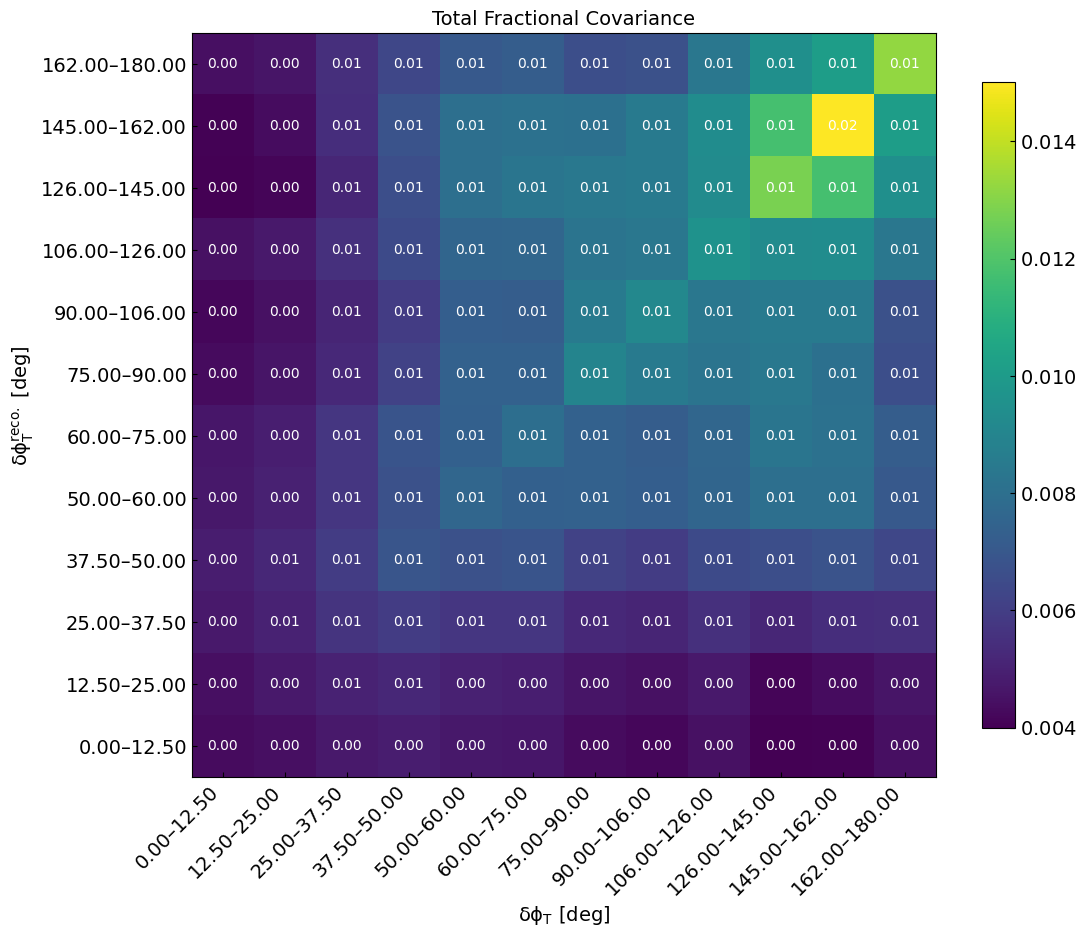

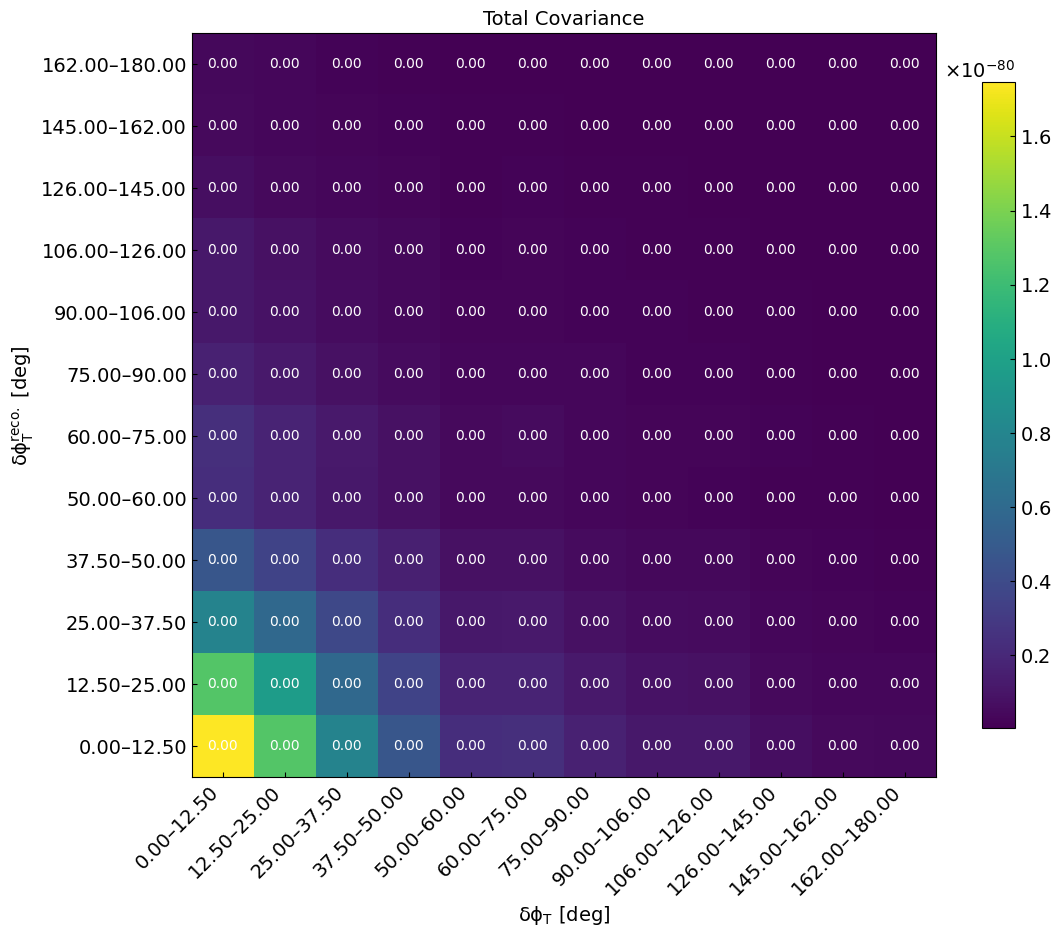

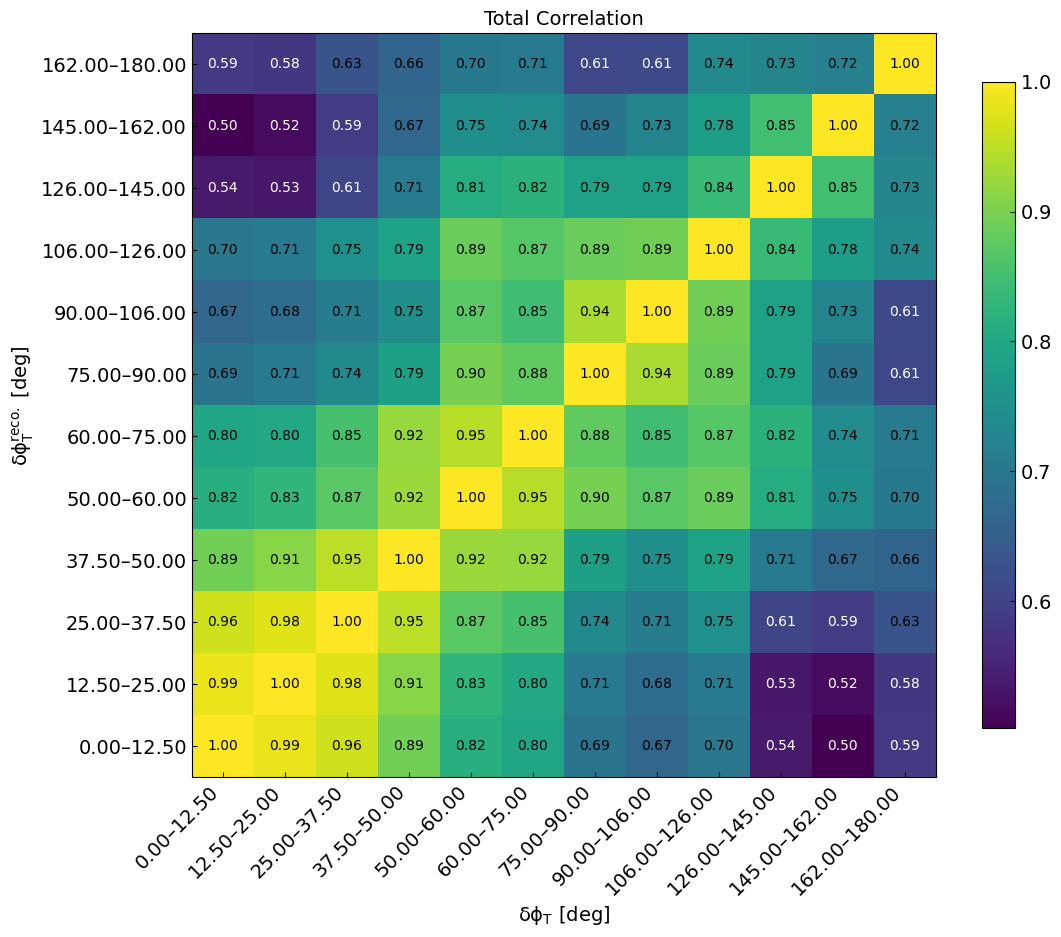

In [130]:
save_fig_name = "{}/{}-total_covariance_frac".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(Total_Covariance_Frac, "Total Fractional Covariance",
             save_fig=False, save_fig_name=save_fig_name)

# covariance in xsec scale
Total_Covariance = cov_from_fraccov(Total_Covariance_Frac, nevts_signal_sel_reco) * XSEC_UNIT**2
save_fig_name = "{}/{}-total_covariance".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(Total_Covariance, "Total Covariance",
             save_fig=False, save_fig_name=save_fig_name)

# correlation
Total_correlation = corr_from_fraccov(Total_Covariance_Frac)
save_fig_name = "{}/{}-total_correlation".format(save_fig_dir, var_config.var_save_name)
plot_heatmap(Total_correlation, "Total Correlation",
             save_fig=False, save_fig_name=save_fig_name)

In [131]:
for k in frac_cov_matrices['singlebin'].keys():
    if "GENIE" not in k:
        print(k)


flux
mcstat
genie_zexp
genie_total


In [132]:
# # for single bin

# # with open(path.join(data_dir, "frac_cov_matrices_final.pkl"), "rb") as f:
# #     frac_cov_matrices = pickle.load(f)

# frac_uncert_flux     = frac_cov_matrices['singlebin']['flux']
# frac_uncert_genie    = frac_cov_matrices['singlebin']['genie_total']
# frac_uncert_mcstat   = frac_cov_matrices['singlebin']['mcstat']
# frac_uncert_total    = np.sqrt(frac_uncert_flux**2 + frac_uncert_genie**2 + frac_uncert_mcstat**2)

# # 10% flat uncertainty for POT
# frac_uncert_detector = np.zeros_like(frac_uncert_flux)
# frac_uncert_detector[:] = 0.1

# # 2% flat uncertainty for POT
# frac_uncert_pot = np.zeros_like(frac_uncert_flux)
# frac_uncert_pot[:] = 0.02

# # 1% for ntargets
# frac_uncert_ntargets = np.zeros_like(frac_uncert_flux)
# frac_uncert_ntargets[:] = 0.01

# # add to total
# frac_uncert_total = np.sqrt(frac_uncert_total**2 + frac_uncert_pot**2 + frac_uncert_ntargets**2 + frac_uncert_detector**2)

# fig, ax = plt.subplots()
# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_pot * 1e2,      histtype="step", linewidth=2, color="C5", label="POT")
# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_ntargets * 1e2, histtype="step", linewidth=2, color="C6", label="Number of Targets")
# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_mcstat * 1e2,   histtype="step", linewidth=2, color="C0", label="MC stat.")
# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie * 1e2,    histtype="step", linewidth=2, color="C2", label="GENIE")
# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_detector * 1e2, histtype="step", linewidth=2, color="C4", label="Detector")
# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_flux * 1e2,     histtype="step", linewidth=2, color="C1", label="Flux")

# plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_total * 1e2,    histtype="step", linewidth=2, color="k",  label="Total")

# plt.text(0.05, 0.5, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

# plt.xlim(var_config.bins[0], var_config.bins[-1])
# plt.xlabel(var_config.var_labels[1])
# plt.ylabel("Uncertainty [%]")
# plt.legend(fontsize=11, ncol=3, loc="upper center", reverse=True)
# plt.ylim(0, max(frac_uncert_total*1e2) * 1.4)

# plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
# plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
# plt.minorticks_on()

# if save_fig:
#     plt.savefig("{}/uncertainty_breakdown-{}.pdf".format(save_fig_dir, "singlebin"), bbox_inches='tight')
# plt.show();

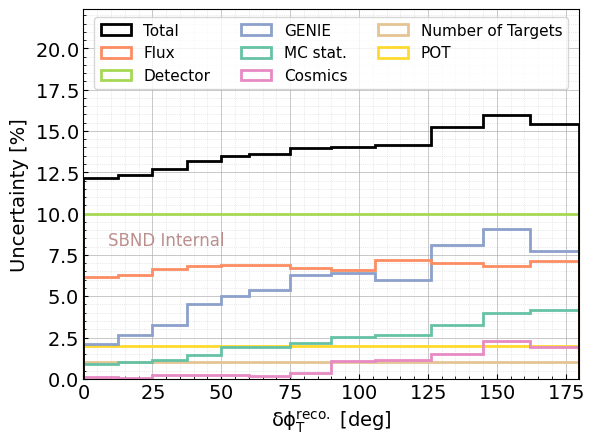

In [134]:
# for multiple bins

# with open(path.join(data_dir, "frac_cov_matrices_final.pkl"), "rb") as f:
#     frac_cov_matrices = pickle.load(f)

frac_uncert_flux     = np.sqrt(np.diag(frac_cov_matrices_newbins[var_name]['flux']))
frac_uncert_genie    = np.sqrt(np.diag(frac_cov_matrices[var_name]['genie_total']))
frac_uncert_cosmics  = np.sqrt(np.diag(frac_cov_matrices_newbins[var_name]['cosmics']))
frac_uncert_mcstat   = np.sqrt(np.diag(frac_cov_matrices_newbins[var_name]['mcstat']))
frac_uncert_total    = np.sqrt(np.diag(Total_Covariance_Frac))

# 10% flat uncertainty for POT
frac_uncert_detector = np.zeros_like(frac_uncert_flux)
frac_uncert_detector[:] = 0.1

# 2% flat uncertainty for POT
frac_uncert_pot = np.zeros_like(frac_uncert_flux)
frac_uncert_pot[:] = 0.02

# 1% for ntargets
frac_uncert_ntargets = np.zeros_like(frac_uncert_flux)
frac_uncert_ntargets[:] = 0.01

# add to total
frac_uncert_total = np.sqrt(frac_uncert_total**2 + frac_uncert_pot**2 + frac_uncert_ntargets**2 + frac_uncert_detector**2)

fig, ax = plt.subplots()
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_pot * 1e2,      histtype="step", linewidth=2, color="C5", label="POT")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_ntargets * 1e2, histtype="step", linewidth=2, color="C6", label="Number of Targets")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_cosmics * 1e2,  histtype="step", linewidth=2, color="C3", label="Cosmics")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_mcstat * 1e2,   histtype="step", linewidth=2, color="C0", label="MC stat.")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie * 1e2,    histtype="step", linewidth=2, color="C2", label="GENIE")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_detector * 1e2, histtype="step", linewidth=2, color="C4", label="Detector")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_flux * 1e2,     histtype="step", linewidth=2, color="C1", label="Flux")

plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_total * 1e2,    histtype="step", linewidth=2, color="k",  label="Total")

plt.text(0.05, 0.4, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=3, loc="upper center", reverse=True)
plt.ylim(0, max(frac_uncert_total*1e2) * 1.4)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig("{}/uncertainty_breakdown-{}.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show();

In [47]:
# choose a variable to unfold, defined in variable_configs.py
var_config = VariableConfig.muon_momentum()
# var_config = VariableConfig.muon_direction()
# var_config = VariableConfig.proton_momentum()
# var_config = VariableConfig.proton_direction()
# var_config = VariableConfig.tki_del_Tp()
# var_config = VariableConfig.tki_del_alpha()
# var_config = VariableConfig.tki_del_phi()

# single bin
# var_config.bins = np.array([var_config.bins[0], var_config.bins[-1]])
# var_config.bin_centers = np.array([var_config.bin_centers[0], var_config.bin_centers[-1]])
# var_config.var_save_name = var_config.var_save_name + "_singlebin"

var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])

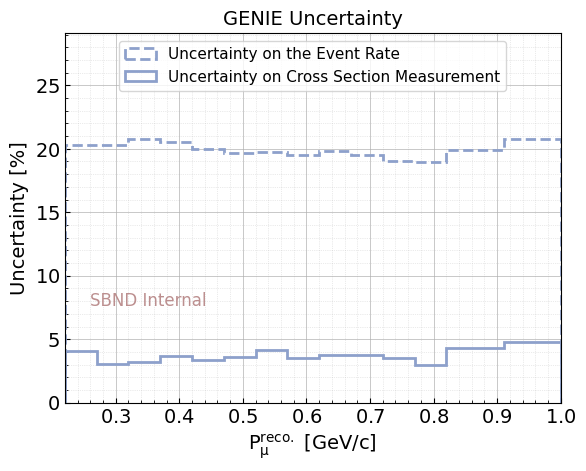

In [48]:

frac_uncert_genie    = np.sqrt(np.diag(frac_cov_matrices[var_name]['genie_total']))
frac_uncert_genie_evt = np.sqrt(np.diag(frac_cov_matrices_genie_evt[var_name]['genie_evt']))

fig, ax = plt.subplots()
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie * 1e2,    histtype="step", 
linewidth=2, color="C2", label="Uncertainty on Cross Section Measurement")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie_evt * 1e2,    histtype="step", 
linewidth=2, linestyle="--", color="C2", label="Uncertainty on the Event Rate")

plt.text(0.05, 0.3, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=1, loc="upper center", reverse=True)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()
plt.title("GENIE Uncertainty")
plt.ylim(0, max(frac_uncert_genie_evt*1e2) * 1.4)

if save_fig:
    plt.savefig("{}/genie_uncertainty_comparison-{}.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show();

In [ ]:
# for single bin

with open(path.join(data_dir, "/exp/sbnd/data/users/munjung/xsec/2025B/frac_cov_matrices_genie_evt.pkl"), "rb") as f:
    frac_cov_matrices_genie_evt = pickle.load(f)

frac_uncert_genie    = frac_cov_matrices['singlebin']['genie_total']
frac_uncert_genie_evt = np.sqrt(np.diag(frac_cov_matrices_genie_evt['singlebin']['genie_evt']))

fig, ax = plt.subplots()
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie * 1e2,    histtype="step", 
linewidth=2, color="C2", label="Uncertainty on Cross Section Measurement")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie_evt * 1e2,    histtype="step", 
linewidth=2, linestyle="--", color="C2", label="Uncertainty on the Event Rate")

plt.text(0.05, 0.5, "SBND Internal", transform=plt.gca().transAxes, fontsize=12, color='rosybrown', ha='left', va='top')

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylabel("Uncertainty [%]")
plt.legend(fontsize=11, ncol=1, loc="upper center", reverse=True)
plt.title("GENIE Uncertainty")
plt.ylim(0, max(frac_uncert_genie_evt*1e2) * 1.4)

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

if save_fig:
    plt.savefig("{}/genie_uncertainty_comparison-{}.pdf".format(save_fig_dir, "singlebin"), bbox_inches='tight')
plt.show();

# Unfolding

In [ ]:
def plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors, labels, 
                            save_fig=False, save_name=None):

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    plt.figure(figsize=(8.5, 6))

    # TODO: make this more general?
    # our categroy breakdown list have signal at the front
    # stack in reverse order so that signal is on top
    var_categ = var_categ[::-1]
    weights_categ = weights_categ[::-1]
    colors = colors[::-1]
    labels = labels[::-1]
    mc_stack, _, _ = plt.hist(var_categ,
                              bins=bins,
                              weights=weights_categ,
                              stacked=True,
                              color=colors,
                              edgecolor='none',
                              linewidth=0,
                              density=False,
                              histtype='stepfilled')

    # background_cv = mc_stack[-1] - mc_stack[0]
    background_cv = mc_stack[-2]

    # use MC as fake data for closure test
    totmc, _ = np.histogram(var_total, bins=bins, weights=weights_total)
    fake_data     = totmc
    fake_data_err = np.sqrt(totmc)
    plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, 
                 fmt='o', color='black')

    # note the % breakdown in the legend
    accum_sum = [0.] + [np.sum(data) for data in mc_stack]
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels.append("Fake Data")
    plt.legend(legend_labels, 
                loc='upper left', 
                fontsize=10, 
                frameon=False, 
                ncol=3, 
                bbox_to_anchor=(0.02, 0.98))

    # leave whitespace at the top for the legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., 1.45 * fake_data.max())

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()
    
    return fake_data, background_cv

In [ ]:
def plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                         plot_labels, 
                         colors, labels, 
                         save_fig=False, save_name=None):

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    plt.figure(figsize=(8.5, 6))

    # stack in reverse order so that signal is on top 
    var_categ = var_categ[::-1]
    weights_categ = weights_categ[::-1]
    colors = colors[::-1]
    labels = labels[::-1]

    mc_stack, _, _ = plt.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')

    # use MC as fake data for closure test
    totmc, bins = np.histogram(var_total, bins=bins, weights=weights_total)
    fake_data     = totmc
    fake_data_err = np.sqrt(totmc)
    plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, 
                 fmt='o', color='black')

    # note the % breakdown in the legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels.append("Fake Data")
    plt.legend(legend_labels, 
                loc='upper left', 
                fontsize=10, 
                frameon=False, 
                ncol=3, 
                bbox_to_anchor=(0.02, 0.98))

    # leave whitespace at the top for the legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., 1.45 * fake_data.max())

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
# --- config for Wiener-SVD unfolding ---
C_type = 2
Norm_type = 0.5

## Closure test 
- use MC signal as fake data

In [ ]:
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=plt.get_cmap('Set1').colors)

In [ ]:
def chi2(data, model, cov):
    return (data - model) @ np.linalg.inv(cov) @ (data - model)

In [ ]:
def plot_unfolded_data(unfold, bins, measured, models,
                         plot_labels, model_names,
                         save_fig=False, save_name=None, mask=False):

    # need to divide by bin width for differential xsec
    bin_widths = np.diff(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # fig, ax = plt.subplots(figsize=(8.5, 6))
    fig, ax = plt.subplots()

    Unfolded = unfold['unfold']

    # --- stat uncertainties
    UnfoldCov_stat = unfold['StatUnfoldCov'] 
    # print(UnfoldCov_stat)
    UnfoldCov_stat = np.diag(measured/XSEC_UNIT)
    # print(UnfoldCov_stat)
    Unfold_uncert_stat = np.diag(UnfoldCov_stat)  * XSEC_UNIT
    # print(Unfold_uncert_stat)
    # print(UnfoldCov_stat)

    # mask = Unfolded != 0
    UnfoldCov_stat_frac = np.zeros_like(UnfoldCov_stat)
    for i in range(len(Unfolded)):
        for j in range(len(Unfolded)):
            if Unfolded[i] != 0 and Unfolded[j] != 0:
                UnfoldCov_stat_frac[i, j] = UnfoldCov_stat[i, j] / (Unfolded[i] * Unfolded[j])
            else:
                UnfoldCov_stat_frac[i, j] = 0.0
    UnfoldCov_stat_frac = UnfoldCov_stat_frac * XSEC_UNIT**2
    # print(UnfoldCov_stat_frac)


    # --- syst uncertainties
    UnfoldCov_syst = unfold['SystUnfoldCov']
    Unfold_uncert_syst = np.diag(UnfoldCov_syst)

    UnfoldCov_syst_frac = np.zeros_like(UnfoldCov_syst)
    for i in range(len(Unfolded)):
        for j in range(len(Unfolded)):
            if Unfolded[i] != 0 and Unfolded[j] != 0:
                UnfoldCov_syst_frac[i, j] = UnfoldCov_syst[i, j] / (Unfolded[i] * Unfolded[j])
            else:
                UnfoldCov_syst_frac[i, j] = 0.0
    # print(UnfoldCov_syst_frac)

    UnfoldedCov_frac = UnfoldCov_stat_frac + UnfoldCov_syst_frac
    UnfoldedCov = np.zeros_like(UnfoldedCov_frac)
    for i in range(len(Unfolded)):
        for j in range(len(Unfolded)):
            UnfoldedCov[i, j] = Unfolded[i] * Unfolded[j] * UnfoldedCov_frac[i, j]


    # decomose into norm and shape components
    # TODO: the first item in models is the true model
    SystUnfoldCov_norm, SystUnfoldCov_shape = Matrix_Decomp(models[0], UnfoldCov_syst)
    Unfold_uncert_norm = np.sqrt(np.abs(np.diag(SystUnfoldCov_norm)))
    Unfold_uncert_shape = np.sqrt(np.abs(np.diag(SystUnfoldCov_shape)))
    # print(Unfold_uncert_stat)
    # print(Unfold_uncert_shape)

    # --- plot
    # unfolded result
    Unfolded_perwidth = Unfolded / bin_widths

    # set err to 0 for closure test
    # plot shape syst and stat as error bars
    Unfold_uncert_stat_perwidth = Unfold_uncert_stat / bin_widths
    Unfold_uncert_shape_perwidth = Unfold_uncert_shape / bin_widths
    # Plot errorbars so that inner cap is stat, outer cap is syst
    # First, plot stat-only errorbars with smaller capsize (inner)
    if not mask:

        bar_handle_stat = plt.errorbar(
            bin_centers, Unfolded_perwidth, 
            yerr=Unfold_uncert_stat_perwidth, 
            fmt='o', color='black', linewidth=1.5, 
            capsize=3, elinewidth=1.5, markeredgewidth=1.5
        )
        # Then, plot total (stat+syst) errorbars with larger capsize (outer), but no marker
        Unfold_uncert_total = np.sqrt(Unfold_uncert_stat_perwidth**2 + Unfold_uncert_shape_perwidth**2)
        bar_handle = plt.errorbar(
            bin_centers, Unfolded_perwidth, 
            yerr=Unfold_uncert_total, 
            fmt='none', ecolor='black', elinewidth=1, capsize=7
        )

    # plot syst norm component as histogram at the bottom
    Unfold_uncert_norm_perwidth = Unfold_uncert_norm / bin_widths
    norm_handle = plt.bar(bin_centers, Unfold_uncert_norm_perwidth, width=bin_widths, label='Syst. error (norm)', alpha=0.5, color='gray')

    # Also divide measured & model by bin width
    measured_perwidth = measured / bin_widths

    # --- get chi2 values for each model to compare
    chi2_vals = []
    model_handles = []
    model_labels = []
    for midx, model in enumerate(models):

        model_smeared = unfold['AddSmear'] @ model
        chi2_val = chi2(Unfolded, model_smeared, UnfoldedCov)
        # chi2_val = chi2(Unfolded, model_smeared, UnfoldCov)
        chi2_vals.append(chi2_val)

        model_smeared_perwidth = model_smeared / bin_widths
        model_handle, = plt.step(bins, np.append(model_smeared_perwidth, model_smeared_perwidth[-1]), where='post', linewidth=2)
        model_handles.append(model_handle)
        model_labels.append(f'$A_c \\otimes$ {model_names[midx]} ($\chi^2$ = {chi2_vals[midx]:.2f}/{len(bins)-1})')

    valign = 0.5
    if not mask:
        handles = [bar_handle_stat, bar_handle]
        labels = [
            'Stat. Unc.',
            'Stat. $\oplus$ Shape Syst. Unc.'
        ]
        main_legend = plt.legend(handles, labels, 
                                    loc='upper left', fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(valign, 0.88),
                                    title="Unfolded Data", title_fontproperties={'weight': 'bold'})

        plt.gca().add_artist(main_legend)
    model_legend = plt.legend(model_handles, model_labels, 
                                loc='upper left', fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(valign, 0.98))

    # leave space for legend
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0., np.max(Unfolded_perwidth)*1.3)

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

    ret_dict = {
        'unfolded': Unfolded,
        'unfolded_perwidth': Unfolded_perwidth,
        'unfold_uncert_stat_perwidth': Unfold_uncert_stat_perwidth,
        'unfold_uncert_shape_perwidth': Unfold_uncert_shape_perwidth,
        'unfold_uncert_total': Unfold_uncert_total,
        'unfold_uncert_norm_perwidth': Unfold_uncert_norm_perwidth,
        'measured_perwidth': measured_perwidth,
        'model_smeared_perwidth': model_smeared_perwidth,
        'chi2_vals': chi2_vals,
    }
    return ret_dict

# On Data

In [ ]:
# Full Covariance Matrix
Covariance_Frac_Flux = frac_cov_matrices[var_name]['flux']
Covariance_Frac_Genie = frac_cov_matrices[var_name]['genie_total']
Covariance_Frac_Cosmics = frac_cov_matrices[var_name]['cosmics']
Covariance_Frac_MCStat = frac_cov_matrices[var_name]['mcstat']

Covariance_Frac_detector = np.diag([0.1**2]*Covariance_Frac_Flux.shape[0])
Covariance_Frac_pot = np.diag([0.02**2]*Covariance_Frac_Flux.shape[0])
Covariance_Frac_ntargets = np.diag([0.01**2]*Covariance_Frac_Flux.shape[0])

Covariance_Frac_Total = Covariance_Frac_Flux + Covariance_Frac_Genie + Covariance_Frac_Cosmics + Covariance_Frac_MCStat
Covariance_Frac_Total = Covariance_Frac_Total + Covariance_Frac_detector + Covariance_Frac_pot + Covariance_Frac_ntargets

# Covariance_Frac_Total = Covariance_Frac_Genie

Covariance_Total = cov_from_fraccov(Covariance_Frac_Total, nevts_signal_sel_reco) * XSEC_UNIT**2

In [ ]:
test_name = ""
var_categ = var_per_nuint_categ_mc
weights_categ = weights_per_categ
colors = topology_colors
labels = topology_labels
var_total = data_evt_df[var_config.var_evt_reco_col]
weights_total = np.ones_like(var_total)
bins = var_config.bins
plot_labels = [var_config.var_labels[1], "Events / Bin"]
save_name = "{}/{}-{}-topology_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

var_categ = var_per_genie_mode_mc
weights_categ = weights_per_genie_mode
colors = genie_mode_colors
labels = genie_mode_labels
save_name = "{}/{}-{}-genie_mode_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                     plot_labels, 
                     colors=colors, labels=labels,
                     save_fig=save_fig, save_name=save_name)

In [ ]:
real_data, _ = np.histogram(data_evt_df[var_config.var_evt_reco_col], bins=var_config.bins)
Measured = real_data * XSEC_UNIT - background_cv * XSEC_UNIT 
Model = nevts_signal_truth * XSEC_UNIT 
Covariance_Input = Covariance_Total
C_type = 2
unfold = WienerSVD(Response, Model, Measured, Covariance_Input, C_type, Norm_type)

In [ ]:
unfold = unfold
measured = Measured
bins = var_config.bins
models = [Model]
model_names = ["AR23"]
plot_labels = [var_config.var_labels[0], var_config.xsec_label]
save_name = "{}/{}-{}-unfolded_event_rates.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
plot_info = plot_unfolded_data(unfold, bins, measured, models, plot_labels, model_names, mask=False)

In [ ]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, test_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

In [ ]:
def fraccov_from_cov(cov, nnom):
    cov_frac = np.zeros_like(cov)
    for i in range(len(cov)):
        for j in range(len(cov)):
            cov_frac[i, j] = cov[i, j] / (nnom[i] * nnom[j])
    return cov_frac

In [ ]:
rot_matrix = unfold['CovRotation']

Covariance_Flux = cov_from_fraccov(Covariance_Frac_Flux, nevts_signal_sel_reco)
unfold_cov_flux = rot_matrix @ Covariance_Flux @ rot_matrix.T
unfold_cov_flux_norm, unfold_cov_flux_shape = Matrix_Decomp(models[0], unfold_cov_flux)
unfold_cov_frac_flux = fraccov_from_cov(unfold_cov_flux,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_flux = np.sqrt(np.diag(unfold_cov_frac_flux))
unfold_cov_frac_flux_norm = fraccov_from_cov(unfold_cov_flux_norm,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_flux_norm = np.sqrt(np.diag(unfold_cov_frac_flux_norm))
unfold_cov_frac_flux_shape = fraccov_from_cov(unfold_cov_flux_shape,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_flux_shape = np.sqrt(np.diag(unfold_cov_frac_flux_shape))

Covariance_Genie = cov_from_fraccov(Covariance_Frac_Genie, nevts_signal_sel_reco)
unfold_cov_genie = rot_matrix @ Covariance_Genie @ rot_matrix.T
unfold_cov_genie_norm, unfold_cov_genie_shape = Matrix_Decomp(models[0], unfold_cov_genie)
unfold_cov_frac_genie = fraccov_from_cov(unfold_cov_genie,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_genie = np.sqrt(np.diag(unfold_cov_frac_genie))
unfold_cov_frac_genie_shape = fraccov_from_cov(unfold_cov_genie_shape,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_genie_shape = np.sqrt(np.diag(unfold_cov_frac_genie_shape))
unfold_cov_frac_genie_norm = fraccov_from_cov(unfold_cov_genie_norm,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_genie_norm = np.sqrt(np.diag(unfold_cov_frac_genie_norm))

Covariance_detector = cov_from_fraccov(Covariance_Frac_detector, nevts_signal_sel_reco)
unfold_cov_detector = rot_matrix @ Covariance_detector @ rot_matrix.T
unfold_cov_detector_norm, unfold_cov_detector_shape = Matrix_Decomp(models[0], unfold_cov_detector)
unfold_cov_frac_detector = fraccov_from_cov(unfold_cov_detector,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_detector = np.sqrt(np.diag(unfold_cov_frac_detector))
unfold_cov_frac_detector_norm = fraccov_from_cov(unfold_cov_detector_norm,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_detector_norm = np.sqrt(np.diag(unfold_cov_frac_detector_norm))
unfold_cov_frac_detector_shape = fraccov_from_cov(unfold_cov_detector_shape,  unfold['unfold']) * XSEC_UNIT**2
unfold_uncert_detector_shape = np.sqrt(np.diag(unfold_cov_frac_detector_shape))

# If any of the norm uncertainties are zero, set them to half of the corresponding shape uncertainty
unfold_uncert_genie_norm = np.where(
    (unfold_uncert_genie_norm == 0) | np.isnan(unfold_uncert_genie_norm),
    0.5 * unfold_uncert_genie_shape,
    unfold_uncert_genie_norm
)
unfold_uncert_detector_norm = np.where(
    (unfold_uncert_detector_norm == 0) | np.isnan(unfold_uncert_detector_norm),
    0.5 * unfold_uncert_detector_shape,
    unfold_uncert_detector_norm
)


bin_centers = var_config.bin_centers
Unfolded_perwidth = plot_info['unfolded_perwidth']
Unfold_uncert_stat_perwidth = plot_info['unfold_uncert_stat_perwidth']
Unfold_uncert_shape_perwidth = plot_info['unfold_uncert_shape_perwidth']
Unfold_uncert_total = plot_info['unfold_uncert_total']
Unfold_uncert_norm_perwidth = plot_info['unfold_uncert_norm_perwidth']
measured_perwidth = plot_info['measured_perwidth']
model_smeared_perwidth = plot_info['model_smeared_perwidth']
chi2_vals = plot_info['chi2_vals']


fig, ax = plt.subplots(2,1, figsize=(8.5, 8))
ratio_xsec = Unfolded_perwidth / model_smeared_perwidth
_ = ax[0].hist(var_config.bin_centers, bins=var_config.bins, weights=ratio_xsec, 
               histtype="step", color="k", linewidth=2, label="C=2 ($\\chi^2$ = {:.2f}/{})".format(chi2_vals[0], len(var_config.bins)-1))

ax[0].set_xlim(var_config.bins[0], var_config.bins[-1])
ax[0].set_ylim(0.5, 1.3)
ax[0].set_ylabel("Unfolded / ($A_c \\otimes$ Model)")
ax[0].axhline(1, color="red", linestyle="--")
# ax[0].legend(loc="upper right", fontsize=10, frameon=True, ncol=1, bbox_to_anchor=(0.98, 0.98))

bin_widths = np.diff(var_config.bins)
syst_norm_uncert_frac = Unfold_uncert_norm_perwidth / Unfolded_perwidth
syst_shape_uncert_frac = Unfold_uncert_shape_perwidth / Unfolded_perwidth
stat_uncert_frac = Unfold_uncert_stat_perwidth / Unfolded_perwidth

norm_handle = ax[1].bar(bin_centers, unfold_uncert_flux_norm, width=bin_widths, label='Flux Unc. (Norm.)', 
                        alpha=1, color='none', hatch='//', edgecolor='C1', linewidth=0)
norm_handle = ax[1].bar(bin_centers, unfold_uncert_genie_norm, width=bin_widths, label='GENIE Unc. (Norm.)', 
                        alpha=1, color='none', hatch='\\\\', edgecolor='C2', linewidth=0)
norm_handle = ax[1].bar(bin_centers, unfold_uncert_detector_norm, width=bin_widths, label='Detector Unc. (Norm.)', 
                        alpha=1, color='none', hatch='||', edgecolor='C4', linewidth=0)
norm_handle = ax[1].bar(bin_centers, syst_norm_uncert_frac, width=bin_widths, label='Total Syst. Unc. (Norm.)', alpha=0.5, color='gray')

ax[1].hist(bin_centers, bins=var_config.bins, weights=unfold_uncert_flux_shape, 
           histtype="step", linewidth=2, label="Flux Unc.", color="C1")
ax[1].hist(bin_centers, bins=var_config.bins, weights=unfold_uncert_genie_shape, 
           histtype="step", linewidth=2, label="Genie Unc.", color="C2")
ax[1].hist(bin_centers, bins=var_config.bins, weights=unfold_uncert_detector_shape, 
           histtype="step", linewidth=2, label="Detector Unc.", color="C4")

# ax[1].hist(bin_centers, bins=var_config.bins, weights=unfold_uncert_detector, 
#            histtype="step", linewidth=2, label="Detector. Unc.", color="C7")

# ax[1].hist(bin_centers, bins=var_config.bins, weights=stat_uncert_frac, 
#            histtype="step", linewidth=2, label="Stat. Unc.", color="C2")
ax[1].hist(bin_centers, bins=var_config.bins, weights=syst_shape_uncert_frac, 
           histtype="step", linewidth=2, label="Total Syst. Unc. (Shape)", color="k", linestyle="--")

ax[1].legend(loc="upper left", fontsize=9, frameon=False, ncol=3, bbox_to_anchor=(0.02, 0.98))

ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Uncertainty [%]")
ax[1].set_ylim(0, max(syst_shape_uncert_frac)*1.35)

test_name = "unfold_data"
plt.savefig("{}/{}-{}-unfold_uncertainty.pdf".format(save_fig_dir, test_name, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
np.sqrt(0.03**2 + 0.06**2)

# Inspect some variables

In [ ]:
mc_proton_bkwd = mc_evt_df[(mc_evt_df.p.pfp.trk.dir.z < 0)]
data_proton_bkwd = data_evt_df[(data_evt_df.p.pfp.trk.dir.z < 0)]

test_name = "mc_proton_bkwd"
var_categ = [mc_proton_bkwd[mc_proton_bkwd.nuint_categ == mode].slc.vertex.x for mode in topology_list] 
weights_categ = [mc_proton_bkwd.loc[mc_proton_bkwd.nuint_categ == mode, 'pot_weight'] for mode in topology_list]
colors = topology_colors
labels = topology_labels
var_total = data_proton_bkwd.slc.vertex.x
weights_total = np.ones_like(var_total)
bins = np.linspace(-200, 200, 20)
plot_labels = ["Slice Vertex X [cm]", "Events / Bin"]
save_name = "{}/{}-{}-topology_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
fake_data, background_cv = plot_topology_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
                            plot_labels, 
                            colors=colors, labels=labels, 
                            save_fig=save_fig, save_name=save_name)

# var_categ = var_per_genie_mode_mc
# weights_categ = weights_per_genie_mode
# colors = genie_mode_colors
# labels = genie_mode_labels
# save_name = "{}/{}-{}-genie_mode_breakdown.pdf".format(save_fig_dir, test_name, var_config.var_save_name)
# plot_genie_breakdown(var_categ, weights_categ, var_total, weights_total, bins,
#                      plot_labels, 
#                      colors=colors, labels=labels,
#                      save_fig=save_fig, save_name=save_name)


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

vertex_diff = (mc_proton_bkwd.slc.vertex.x - mc_proton_bkwd.position.x)
ax[0].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.slc.vertex.x - mc_evt_df.position.x)
ax[0].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[0].set_xlabel("Slice Vertex X (Reco. - True) [cm]")
ax[0].set_ylabel("Events / Bin")

vertex_diff = (mc_proton_bkwd.slc.vertex.y - mc_proton_bkwd.position.y)
ax[1].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.slc.vertex.y - mc_evt_df.position.y)
ax[1].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[1].set_xlabel("Slice Vertex Y (Reco. - True) [cm]")
ax[1].set_ylabel("Events / Bin")

vertex_diff = (mc_proton_bkwd.slc.vertex.z - mc_proton_bkwd.position.z)
ax[2].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.slc.vertex.z - mc_evt_df.position.z)
ax[2].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[2].set_xlabel("Slice Vertex Z (Reco. - True) [cm]")
ax[2].set_ylabel("Events / Bin")

ax[2].legend(loc="upper left", fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(0.02, 0.98))

plt.savefig("slice_vertex_difference.pdf", bbox_inches='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

vertex_diff = (mc_proton_bkwd.p.pfp.trk.start.x - mc_proton_bkwd.p.pfp.trk.truth.p.start.x)
ax[0].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.p.pfp.trk.start.x - mc_evt_df.p.pfp.trk.truth.p.start.x)
ax[0].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[0].set_xlabel("Track Start X (Reco. - True) [cm]")
ax[0].set_ylabel("Events / Bin")

vertex_diff = (mc_proton_bkwd.p.pfp.trk.start.y - mc_proton_bkwd.p.pfp.trk.truth.p.start.y)
ax[1].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.p.pfp.trk.start.y - mc_evt_df.p.pfp.trk.truth.p.start.y)
ax[1].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[1].set_xlabel("Track Start Y (Reco. - True) [cm]")
ax[1].set_ylabel("Events / Bin")

vertex_diff = (mc_proton_bkwd.p.pfp.trk.start.z - mc_proton_bkwd.p.pfp.trk.truth.p.start.z)
ax[2].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.p.pfp.trk.start.z - mc_evt_df.p.pfp.trk.truth.p.start.z)
ax[2].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[2].set_xlabel("Track Start Z (Reco. - True) [cm]")
ax[2].set_ylabel("Events / Bin")

ax[2].legend(loc="upper left", fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(0.02, 0.98))

plt.savefig("slice_vertex_difference.pdf", bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

vertex_diff = (mc_proton_bkwd.p.pfp.trk.start.x - mc_proton_bkwd.slc.vertex.x)
ax[0].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.p.pfp.trk.start.x - mc_evt_df.slc.vertex.x)
ax[0].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[0].set_xlabel("Track Start X - Slice Vertex X [cm]")
ax[0].set_ylabel("Events / Bin")

vertex_diff = (mc_proton_bkwd.p.pfp.trk.start.y - mc_proton_bkwd.slc.vertex.y)
ax[1].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.p.pfp.trk.start.y - mc_evt_df.slc.vertex.y)
ax[1].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[1].set_xlabel("Track Start Y - Slice Vertex Y [cm]")
ax[1].set_ylabel("Events / Bin")

vertex_diff = (mc_proton_bkwd.p.pfp.trk.start.z - mc_proton_bkwd.slc.vertex.z)
ax[2].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="leading p bkwd")
vertex_diff = (mc_evt_df.p.pfp.trk.start.z - mc_evt_df.slc.vertex.z)
ax[2].hist(vertex_diff, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all p")
ax[2].set_xlabel("Track Start Z - Slice Vertex Z [cm]")
ax[2].set_ylabel("Events / Bin")

ax[2].legend(loc="upper left", fontsize=10, frameon=False, ncol=1, bbox_to_anchor=(0.02, 0.98))

plt.savefig("slice_vertex_difference.pdf", bbox_inches='tight')
plt.show()

In [ ]:
mc_evt_df.pdg.unique()

In [ ]:
mc_cosmic = mc_evt_df[np.isnan(mc_evt_df.pdg)]

var = mc_evt_df.del_Tp
plt.hist(var, bins=np.linspace(0, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all nu")
var = mc_cosmic.del_Tp
plt.hist(var, bins=np.linspace(0, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="cosmic")
var = mc_evt_df[(mc_evt_df.genie_mode == 0) & (mc_evt_df.iscc == 1)].del_Tp
plt.hist(var, bins=np.linspace(0, 1, 40), histtype="step", linewidth=2, color="C1", density=True, label="all numu cc qe")
plt.xlabel("del_Tp ")
plt.ylabel("Events / Bin")
plt.legend(loc="upper right", fontsize=10, frameon=False, ncol=1)
plt.show()

var = mc_evt_df.del_phi
plt.hist(var, bins=np.linspace(0, 180, 40), histtype="step", linewidth=2, color="k", density=True, label="all nu")
var = mc_cosmic.del_phi
plt.hist(var, bins=np.linspace(0, 180, 40), histtype="step", linewidth=2, color="C0", density=True, label="cosmic")
var = mc_evt_df[(mc_evt_df.genie_mode == 0) & (mc_evt_df.iscc == 1)].del_phi
plt.hist(var, bins=np.linspace(0, 180, 40), histtype="step", linewidth=2, color="C1", density=True, label="all numu cc qe")
plt.xlabel("del_phi [deg]")
plt.ylabel("Events / Bin")
plt.legend(loc="upper right", fontsize=10, frameon=False, ncol=1)
plt.show()

var = mc_evt_df.del_alpha
plt.hist(var, bins=np.linspace(0, 180, 40), histtype="step", linewidth=2, color="k", density=True, label="all nu")
var = mc_cosmic.del_alpha
plt.hist(var, bins=np.linspace(0, 180, 40), histtype="step", linewidth=2, color="C0", density=True, label="cosmic")
var = mc_evt_df[(mc_evt_df.genie_mode == 0) & (mc_evt_df.iscc == 1)].del_alpha
plt.hist(var, bins=np.linspace(0, 180, 40), histtype="step", linewidth=2, color="C1", density=True, label="all numu cc qe")
plt.xlabel("del_alpha ")
plt.ylabel("Events / Bin")
plt.legend(loc="upper left", fontsize=10, frameon=False, ncol=1)
plt.show()

In [ ]:
var = np.cos(mc_evt_df.del_phi)
plt.hist(var, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="k", density=True, label="all nu")
var = np.cos(mc_cosmic.del_phi)
plt.hist(var, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C0", density=True, label="cosmic")
var = np.cos(mc_evt_df[(mc_evt_df.genie_mode == 0) & (mc_evt_df.iscc == 1)].del_phi)
plt.hist(var, bins=np.linspace(-1, 1, 40), histtype="step", linewidth=2, color="C1", density=True, label="all numu cc qe")
plt.xlabel("cos(del_phi)")
plt.ylabel("Events / Bin")
plt.show()